In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.stats import norm, skewnorm
from scipy.optimize import curve_fit
from sklearn import linear_model, datasets
import bokeh
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Range1d, Ticker, Label
from bokeh.layouts import gridplot, layout
import bokeh.palettes as palettes
output_notebook()


C:\Users\Sarah\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


Loading BokehJS ...

In [2]:
def Figure(*args, **kwargs):
    fig = figure(*args, **kwargs)
    fig.title.text_font_size = '13pt'
    fig.xaxis.axis_label_text_font_size = "13pt"
    fig.yaxis.axis_label_text_font_size = "13pt"
    fig.xaxis.major_label_text_font_size = "13pt"
    fig.yaxis.major_label_text_font_size = "13pt"
    return fig

# Import GDR2 data

In [3]:
Gaia = pd.read_csv('Data\GDR2.csv')
usedQuantities_Gaia = ['phot_g_mean_mag','phot_g_mean_flux_over_error','phot_bp_mean_mag','phot_bp_mean_flux_over_error','phot_rp_mean_mag','phot_rp_mean_flux_over_error']
Gaia.dropna(subset=usedQuantities_Gaia, inplace=True)
print('Number of stars in GDR2: ', len(Gaia))

C:\Users\Sarah\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (215,228) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of stars in GDR2:  175162


# Import Dambis data

In [4]:
Dambis = pd.read_csv('Data\RRL_Dambis2013.csv')
usedQuantities_Dambis = ['FeH']
Dambis.dropna(subset=usedQuantities_Dambis, inplace=True)
print('Number of stars in Dambis: ', len(Dambis))

Number of stars in Dambis:  402


# Mean G magnitude and uncertainty

In [5]:
G = Gaia['phot_g_mean_mag']
G_error = 2.5/(np.log(10)*Gaia['phot_g_mean_flux_over_error'])

# Metallicity

## Metallicity histogram of Dambis sample

In [6]:
hist, edges = np.histogram(Dambis['FeH'], density=False, bins=30)
tools = "pan, wheel_zoom, box_zoom, box_select, save, reset"
title = 'Sample of Dambis et al (2013)'

fig = Figure(width=700, height=500, x_axis_label='[Fe/H]', y_axis_label='Count', x_range=(-3.1,0.6), title=title, tools=tools)
fig.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color='black')
show(fig)


## Metallicity histogram of GDR2 sample

In [7]:
hist, edges = np.histogram(Gaia['metallicity'].dropna(), density=False, bins=30)
tools = "pan, wheel_zoom, box_zoom, box_select, save, reset"
title = 'Gaia DR2 sample'

fig = Figure(width=700, height=500, x_axis_label='[Fe/H]', y_axis_label='Count', x_range=(-3.1,0.6), title=title, tools=tools)
fig.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color='black')
show(fig)

## Comparison Dambis FeH and GDR2 metallicity

In [8]:
Xmatch = pd.read_csv("Data\DambisGaiaXmatch.csv")
intermediate = pd.merge(Xmatch, Dambis, how="inner", left_on=["Identifier"], right_on=["Name"])
subDambis = pd.merge(intermediate, Gaia, how="inner", left_on=["GaiaID"], right_on=["designation"])
usedQuantities = ['FeH', 'metallicity']
subDambis.dropna(subset=usedQuantities, inplace=True)
print("Number of Dambis stars with GDR2 photometric metallicity: ", len(subDambis))

Number of Dambis stars with GDR2 photometric metallicity:  224


In [9]:
tools = "pan, wheel_zoom, box_zoom, box_select, save, reset"
title = 'Dambis spectroscopic vs GDR2 photometric metallicity of RR Lyr stars'

fig = Figure(width=700, height=500, x_axis_label='Dambis Metallicity', y_axis_label='GDR2 Metallicity', title=title, tools=tools)
fig.circle(subDambis['FeH'], subDambis['metallicity'])
fig.line([-3, 0.5], [-3, 0.5], color="red")
show(fig)

In [10]:
slope, intercept = np.polyfit(subDambis['FeH'], subDambis['metallicity'], 1)
print("Slope: ", slope)
print("Intercept: ",intercept)

Slope:  0.816518239982
Intercept:  -0.0682403116796


In [11]:
X = np.ones([len(subDambis), 2])
X[:,0] = subDambis['FeH']
y = subDambis['metallicity']
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
slope, intercept = ransac.estimator_.coef_
print("RANSAC Slope: ", slope)
print("RANSAC Intercept: ", intercept)

RANSAC Slope:  1.15984925322
RANSAC Intercept:  0.0


# Mean absolute G magnitude and uncertainty

M_G-[Fe/H] relation and coefficients from Muraveva et al. (2018)

In [12]:
a = 0.32
a_error = 0.04
b = 1.11
b_error = 0.06
Cov_ab = 0.95*0.04*0.06

Z = Dambis['FeH']
abs_mag = a*Z + b

Fit Gaussian to absolute magnitudes from Dambis sample

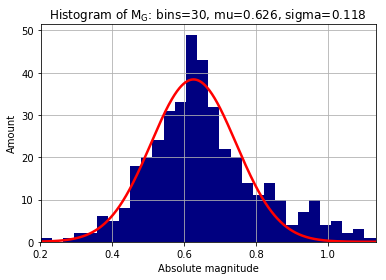

In [13]:
def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))

bin = 30
bins = np.linspace(min(abs_mag),max(abs_mag), bin+1)
hist, edges = np.histogram(abs_mag, density=False, bins=bins)
binscenters = np.array([(edges[i] + edges[i+1])/2 for i in range(len(edges)-1)])
popt, pcov = curve_fit(gauss, xdata=binscenters, ydata=hist, p0=[max(hist), np.mean(abs_mag), np.std(abs_mag)])


xspace = np.linspace(min(abs_mag), max(abs_mag), 100000)
plt.bar(binscenters, hist, width=(edges[1]-edges[0]), color='navy')
plt.plot(xspace, gauss(xspace, *popt), color='red', linewidth=2.5)
plt.xlim(min(abs_mag),max(abs_mag))
plt.xlabel('Absolute magnitude')
plt.ylabel('Amount')
plt.title('Histogram of $\mathrm{M_G}$: bins=%d, mu=%.3f, sigma=%.3f' %(bin,popt[1],popt[2]))
plt.grid(True)
plt.show()


In [14]:
M_G = popt[1]
M_G_var = a**2*np.var(Z) + np.mean(Z**2)*a_error**2 + b_error**2 + 2*np.mean(Z)*Cov_ab
print(M_G, np.sqrt(M_G_var))
M_G_error = np.full(len(G_error),np.sqrt(M_G_var))

0.625901501839 0.157333499401


# Extiction and uncertainty

In [15]:
A = 0.97883
B = -0.14365
C = 0.011077
D = 0.034842
E = -0.0041448

def f(bp_rp,a_v):
    return A + B*(bp_rp) + C*(bp_rp)**2 + D*a_v + E*a_v*(bp_rp)

BP_RP = Gaia['phot_bp_mean_mag']-Gaia['phot_rp_mean_mag']
BP_error = 2.5/(np.log(10)*Gaia['phot_bp_mean_flux_over_error'])
RP_error = 2.5/(np.log(10)*Gaia['phot_rp_mean_flux_over_error'])
BP_RP_error = np.sqrt(BP_error**2+RP_error**2)

A_V = 2.742*Gaia['EBV_sfd']
A_V_error = 2.742*0.16*abs(Gaia['EBV_sfd'])

A_G = f(BP_RP,A_V)*A_V

Monte Carlo to find uncertainty of A_G

In [18]:
'''
mean = []
A_G_error = []
w = csv.writer(open("A_G_error.csv","w"))
for i in range(len(A_G)):
    print(i)
    if not (i==121573 or i==166300): #no BP_RP for these rows
        MCE=[]
        for j in range(1000):
            MCBP_RP = BP_RP[i] + np.random.normal(0,1)*BP_RP_error[i]
            MCA_V = A_V[i] + np.random.normal(0,1)*A_V_error[i]
            MCA_G = f(MCBP_RP,MCA_V)*MCA_V
            MCE.append(MCA_G)
        mean.append(np.mean(MCE))
        A_G_error.append(np.std(MCE))
        w.writerow([A_G[i],np.mean(MCE),np.std(MCE)])
'''

'\nmean = []\nA_G_error = []\nw = csv.writer(open("A_G_error.csv","w"))\nfor i in range(len(A_G)):\n    print(i)\n    if not (i==121573 or i==166300): #no BP_RP for these rows\n        MCE=[]\n        for j in range(1000):\n            MCBP_RP = BP_RP[i] + np.random.normal(0,1)*BP_RP_error[i]\n            MCA_V = A_V[i] + np.random.normal(0,1)*A_V_error[i]\n            MCA_G = f(MCBP_RP,MCA_V)*MCA_V\n            MCE.append(MCA_G)\n        mean.append(np.mean(MCE))\n        A_G_error.append(np.std(MCE))\n        w.writerow([A_G[i],np.mean(MCE),np.std(MCE)])\n'

# Distance

In [17]:
d = 10**((G-A_G-M_G+5)/5)*10**(-3)

hist, edges = np.histogram(d, density=False, bins=100)
tools = "pan, wheel_zoom, box_zoom, box_select, save, reset"
title = 'RR Lyrae distances'

fig = Figure(width=700, height=500, x_axis_label='Distance (kpc)', y_axis_label='Count', title=title, tools=tools)
fig.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color='black')
show(fig)

In [19]:
# load errors for A_G from file
A_G_file = pd.read_csv('Distance\A_G_error.csv')
usedQuantities_A_G_file = ['std']
A_G_file.dropna(subset=usedQuantities_A_G_file, inplace=True)
A_G_error = A_G_file['std']

d_error = d*(np.log(10)/5)*np.sqrt(G_error**2+A_G_error**2+M_G_error**2)

hist, edges = np.histogram(d_error, density=False, bins=100)
tools = "pan, wheel_zoom, box_zoom, box_select, save, reset"
title = 'RR Lyrae distance uncertainties'

fig = Figure(width=700, height=500, x_axis_label='Uncertainty on distance (kpc)', y_axis_label='Count', title=title, tools=tools)
fig.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color='black')
show(fig)

Save distances and uncertainties to file

In [46]:
with open('distance.csv','w') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerows(zip(Gaia['ra'],Gaia['dec'],A_G,d,d_error))